In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures

SCALE = 7.35
N = 10000
N_BINS = 160

# 1 
Generar una muestra aleatoria de $10,000$ puntos de la distribución de $Rayleigh$ utilizando `scale = 7.53`.

In [2]:
def rayleigh_pdf(n_samples, scale=SCALE):
    rx = np.linspace(0, max(rayleigh_data), n_samples)
    return ((rx /SCALE **2) * np.exp(-rx**2 / (2 * SCALE**2)))

# Datos de entrada (features)
rayleigh_data = np.random.rayleigh(scale=SCALE, size=N)
# Datos reales (labels)
rx = np.linspace(0, max(rayleigh_data), N)
ray_pdf = rayleigh_pdf(N) 

rayleigh_data.shape, ray_pdf.shape 

((10000,), (10000,))

# 2
Obtén $160$ puntos del histograma de tu muestra.

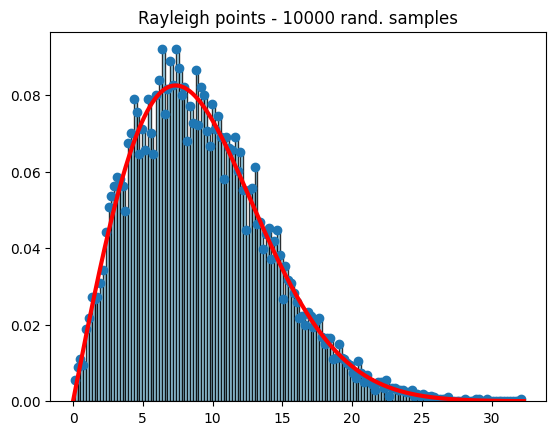

In [3]:
hist, bin_edges = np.histogram(rayleigh_data, bins=N_BINS, density=True)
plt.hist(rayleigh_data, bins=N_BINS, density=True, alpha=0.8, color='skyblue', edgecolor='black')
plt.scatter(bin_edges[:-1],hist)
plt.plot(rx, ray_pdf, 'r', linewidth=3)
plt.title('Rayleigh points - 10000 rand. samples')
plt.show()

# 3
Divide los puntos en conjunto de entrenamiento y prueba (80-20).

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(bin_edges[:-1], hist, test_size=0.2, random_state=0)
X_train.shape, Y_train.shape, Y_test.shape, Y_test.shape

((128,), (128,), (32,), (32,))

# 4 
Realiza una regresión polinomial del conjunto de entrenamiento probando distintos grados
de polinomio. Calcula el sesgo y varianza para cada grado utilizado (Es posible que
tengas que dividir tu conjunto de entrenamiento en entrenamiento y validación). Imprime
los resultados en un dataframe de pandas: grado del polinomio, sesgo, varianza, $MAE,
MSE, R2$.

In [30]:
def reshape_data(X, y):
    return X.reshape(-1,1), y.reshape(-1,1)

def to_polynomial(X, deg):
    return PolynomialFeatures(degree=deg).fit_transform(X)

def polynomial_model_df(max_deg):
    df = pd.DataFrame(columns=['grado_modelo', 'mae', 'mse', 'r2_score', 'sesgo', 'varianza'])
    
    for deg in range(1, max_deg + 1):
        x_train, y_train = reshape_data(X_train, Y_train)
        x_test, y_test   = reshape_data(X_test, Y_test)
        x_train_pol = to_polynomial(x_train, deg)
        x_test_pol  = to_polynomial(x_test, deg)
        model   = LinearRegression().fit(x_train_pol, y_train)
        y_hat   = model.predict(x_test_pol)
        
        mae  = mean_absolute_error(y_test, y_hat)
        mse  = mean_squared_error(y_test, y_hat)
        r2   = r2_score(y_test, y_hat)
        bias = np.mean(((x_test_pol) - np.mean(y_hat))**2)
        var  = np.var(y_hat)
        
        df.loc[len(df.index)] = [deg, mae, mse, r2, bias, var]
        
    return df
        #y_train = PolynomialFeatures(degree=deg).fit_transform(y_train)
        #results = cross_validate(model, x_train, y_train, 
        #                        cv=5, n_jobs=-1, 
        #                        scoring=('neg_mean_absolute_error',
        #                                 'neg_mean_squared_error', 
        #                                 'r2'))
        #print(f"Modelo de grado {deg}\n")
        #print(f"MAE: {max(results['test_neg_mean_absolute_error'])}")
        #print(f"MSE: {max(results['test_neg_mean_squared_error'])}")
        #print(f"R2: {max(results['test_r2'])}")
        #print()

In [31]:
df = polynomial_model_df(10)
df

,grado_modelo,mae,mse,r2_score,sesgo,varianza
0,1.0,0.015259,0.000356,0.634228,1.750145e+02,0.000400
1,2.0,0.015836,0.000330,0.660492,6.652108e+04,0.000427
2,3.0,0.007440,0.000072,0.926406,3.331625e+07,0.000938
3,4.0,0.002890,0.000016,0.983630,1.927635e+10,0.000899
4,5.0,0.002941,0.000016,0.983895,1.219604e+13,0.000905
5,6.0,0.002346,0.000011,0.988218,8.199434e+15,0.000932
6,7.0,0.002271,0.000011,0.988580,5.758374e+18,0.000932
7,8.0,0.002269,0.000011,0.988498,4.178197e+21,0.000932
8,9.0,0.002305,0.000011,0.988437,3.108890e+24,0.000933
9,10.0,0.002233,0.000011,0.988564,2.359670e+27,0.000937


# 5
Repite el análisis del punto 4 pero utilizando regularización y validación cruzada.

In [34]:
def polynomial_model_ridgecv(max_deg):
    df = pd.DataFrame(columns=['grado_modelo', 'mae', 'mse', 'r2_score', 'sesgo', 'varianza'])
    
    for deg in range(1, max_deg + 1):
        x_train, y_train = reshape_data(X_train, Y_train)
        x_test, y_test   = reshape_data(X_test, Y_test)
        x_train_pol      = to_polynomial(x_train, deg)
        x_test_pol       = to_polynomial(x_test, deg)
        model   = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x_train_pol, y_train)
        y_hat   = model.predict(x_test_pol)
        
        mae  = mean_absolute_error(y_test, y_hat)
        mse  = mean_squared_error(y_test, y_hat)
        r2   = model.score(x_test_pol, y_test)
        bias = np.mean(((x_test_pol) - np.mean(y_hat))**2)
        var  = np.var(y_hat)
        
        df.loc[len(df.index)] = [deg, mae, mse, r2, bias, var]
        
    return df

In [35]:
df_2 = polynomial_model_ridgecv(10)
df_2

,grado_modelo,mae,mse,r2_score,sesgo,varianza
0,1.0,1.525948e-02,3.558496e-04,6.342091e-01,1.750145e+02,4.002503e-04
1,2.0,1.583600e-02,3.302804e-04,6.604926e-01,6.652108e+04,4.272491e-04
2,3.0,7.438287e-03,7.157626e-05,9.264241e-01,3.331625e+07,9.375909e-04
3,4.0,3.017043e-03,1.694423e-05,9.825824e-01,1.927635e+10,8.685264e-04
4,5.0,7.089332e-01,7.165170e-01,-7.355342e+02,1.219604e+13,6.706824e-01
5,6.0,1.153112e+03,1.913472e+06,-1.966928e+09,8.199425e+15,1.860686e+06
6,7.0,4.990863e+05,3.663084e+11,-3.765418e+14,5.758487e+18,3.513022e+11
7,8.0,5.480634e+08,4.429778e+17,-4.553532e+20,4.181726e+21,4.180885e+17
8,9.0,3.664492e+11,1.938473e+23,-1.992628e+26,3.188342e+24,1.796568e+23
9,10.0,8.052831e+14,9.225299e+29,-9.483024e+32,9.124833e+28,8.376573e+29


In [36]:
df.iloc[df['r2_score'].argmax()], df_2.iloc[df_2['r2_score'].argmax()]

(grado_modelo    7.000000e+00
 mae             2.270608e-03
 mse             1.110979e-05
 r2_score        9.885798e-01
 sesgo           5.758374e+18
 varianza        9.315425e-04
 Name: 6, dtype: float64,
 grado_modelo    4.000000e+00
 mae             3.017043e-03
 mse             1.694423e-05
 r2_score        9.825824e-01
 sesgo           1.927635e+10
 varianza        8.685264e-04
 Name: 3, dtype: float64)

In [15]:
9.825824e-01 < 9.885798e-01

True

In [38]:
def build_model(model_deg):
    x_train, y_train = reshape_data(X_train, Y_train)
    x_test, y_test   = reshape_data(X_test, Y_test)
    x_train_pol      = to_polynomial(x_train, model_deg)
    x_test_pol       = to_polynomial(x_test, model_deg)
    model   = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x_train_pol, y_train)
    return model

model = build_model(4)